In [1]:
%pylab inline

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_train_test, split_x_y
from tools import vis_evaluate

from pprint import pprint as pp
from IPython.display import display

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


# Dataset

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) 에서 다운받을 수 있습니다.


1. **date**: Date in format dd/mm/yyyy
2. **time**: time in format hh:mm:ss
3. **global_active_power**: household global minute-averaged active power (in kilowatt). Global active power is the power consumed by appliances other than the appliances mapped to Sub Meters. Global active power is the real power consumption i.e. the power consumed by electrical appliances other than the sub metered appliances.It is basically called wattfull power.
4. **global_reactive_power**: household global minute-averaged reactive power (in kilowatt). Global reactive power is the power which bounces back and froth without any usage or leakage. It is the imaginary power consumption. It is basically called wattless power.
5. **voltage**: minute-averaged voltage (in volt)

6. **global_intensity**: household global minute-averaged current intensity (in ampere). Intensity is magnitude of the power consumed. Also called as strength of current.

7. **sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. **sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. **sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

10. **diff_next**: 다음시간대와 비교하여 difference


하려고 하는 것은 [유효전력(global active power)](http://www.ktword.co.kr/abbr_view.php?m_temp1=4091)를 예측하는 것입니다.


# Configuration

In [3]:
PREDICT_SIZE = 64
BATCH_SIZE = 2048

# Load Dataset

In [11]:
dataset = load_household_power_consumption()
data_x, data_y = split_x_y(dataset)

# Add Y
dataset['active_power_p'] = dataset['active_power'].shift(-PREDICT_SIZE)
dataset.dropna(inplace=True)
display(dataset.head())
display(dataset.iloc[PREDICT_SIZE:].head())


2017-08-22 19:21:24,433 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,diff_next,active_power_p
datetime,,,,,,,,,
2010-10-27 13:40:00,0.596,0.000,246.50,2.6,0.0,0.0,0.0,60.0,0.374
2010-10-27 13:41:00,0.576,0.000,247.09,2.4,0.0,0.0,1.0,60.0,0.344
2010-10-27 13:42:00,0.524,0.084,247.52,2.2,0.0,0.0,1.0,60.0,0.336
2010-10-27 13:43:00,0.524,0.084,247.45,2.2,0.0,0.0,0.0,60.0,0.374
2010-10-27 13:44:00,0.520,0.086,246.33,2.2,0.0,0.0,1.0,60.0,0.420


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,diff_next,active_power_p
datetime,,,,,,,,,
2010-10-27 14:44:00,0.374,0.064,250.78,1.6,0.0,0.0,1.0,60.0,0.548
2010-10-27 14:45:00,0.344,0.064,250.47,1.4,0.0,0.0,1.0,60.0,0.492
2010-10-27 14:46:00,0.336,0.062,249.66,1.4,0.0,0.0,0.0,60.0,0.520
2010-10-27 14:47:00,0.374,0.000,249.97,1.6,0.0,0.0,1.0,60.0,0.512
2010-10-27 14:48:00,0.420,0.046,250.26,1.6,0.0,0.0,1.0,60.0,0.486


## Pearson Correlation

active_power_p    1.000000
active_power      0.441844
intensity         0.441189
voltage           0.384624
sub3              0.285077
sub2              0.143397
sub1              0.103186
reactive_power    0.087978
diff_next         0.007942
Name: active_power_p, dtype: float64

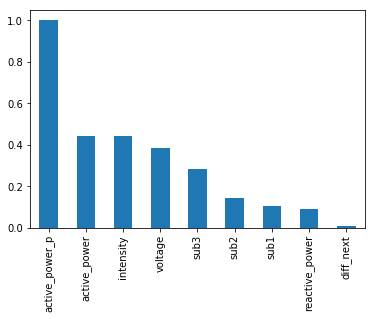

In [12]:
def show_correlation(data):
    d = np.sqrt((data.corr()['active_power_p']**2)).sort_values(ascending=False)
    display(d)
    d.plot(kind='bar')
    
show_correlation(dataset)

## Lagged Correlation

In [29]:
dataset.shift(-5)['active_power']

datetime
2010-10-27 13:40:00    0.522
2010-10-27 13:41:00    0.520
2010-10-27 13:42:00    0.518
2010-10-27 13:43:00    0.520
2010-10-27 13:44:00    0.518
2010-10-27 13:45:00    0.518
2010-10-27 13:46:00    0.520
2010-10-27 13:47:00    0.522
2010-10-27 13:48:00    0.542
2010-10-27 13:49:00    0.624
2010-10-27 13:50:00    0.622
2010-10-27 13:51:00    0.618
2010-10-27 13:52:00    0.616
2010-10-27 13:53:00    0.614
2010-10-27 13:54:00    0.614
2010-10-27 13:55:00    0.612
2010-10-27 13:56:00    0.610
2010-10-27 13:57:00    0.610
2010-10-27 13:58:00    0.610
2010-10-27 13:59:00    0.610
2010-10-27 14:00:00    0.612
2010-10-27 14:01:00    0.598
2010-10-27 14:02:00    0.516
2010-10-27 14:03:00    0.514
2010-10-27 14:04:00    0.514
2010-10-27 14:05:00    0.550
2010-10-27 14:06:00    0.590
2010-10-27 14:07:00    0.592
2010-10-27 14:08:00    0.592
2010-10-27 14:09:00    0.588
                       ...  
2010-11-26 19:28:00    1.870
2010-11-26 19:29:00    1.864
2010-11-26 19:30:00    2.754
2010-

In [35]:
# dataset.shift(-1)['active_power']

for i in range(60*60):
    corr = dataset['active_power'][i:].corr(dataset.shift(-i)['active_power'].dropna())
    print(f'[{i}] {corr}')
    
    

[0] 0.9999999999999999
[1] 0.9739529393247494
[2] 0.9467692908984544
[3] 0.9264408408707474
[4] 0.9048660562696074
[5] 0.883082425847818
[6] 0.8628047001171866
[7] 0.8427046258239024
[8] 0.8225436607695783
[9] 0.8044490696229561
[10] 0.786359359552851
[11] 0.7679497304917862
[12] 0.7517225395270913
[13] 0.7371054130447121
[14] 0.724571808239191
[15] 0.7142614599928313
[16] 0.7045347690718737
[17] 0.6953956380174882
[18] 0.6874515541715751
[19] 0.6791496120188948
[20] 0.6706878914354413
[21] 0.6634858727827887
[22] 0.6561953288628515
[23] 0.6474026325961731
[24] 0.6401052292709097
[25] 0.6331061599447062
[26] 0.6249550766062383
[27] 0.6176352482118742
[28] 0.6105508060399797
[29] 0.6021273082194853
[30] 0.5940891495538195
[31] 0.5868410267801426
[32] 0.5785833619373577
[33] 0.5706393326362006
[34] 0.5634405327452254
[35] 0.5562077480685095
[36] 0.5488185575323156
[37] 0.5417256827352274
[38] 0.5352674803227934
[39] 0.5291132378732718
[40] 0.5230246973432511
[41] 0.5171344242603796
[42] 

## Scatter Plots

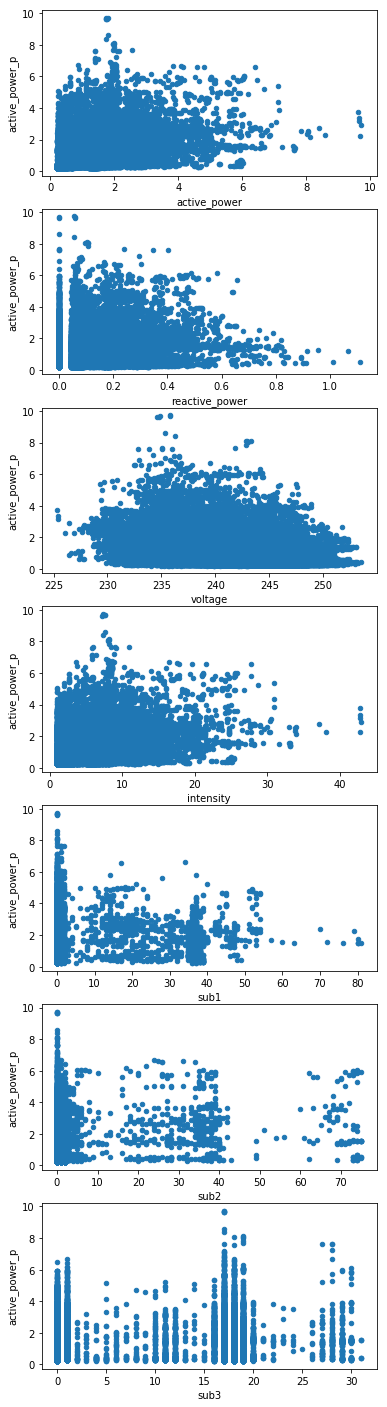

In [13]:
fig, plots = subplots(7, 1)
fig.set_figheight(25)

dataset.plot('active_power', 'active_power_p', kind='scatter', ax=plots[0])
dataset.plot('reactive_power', 'active_power_p', kind='scatter', ax=plots[1])
dataset.plot('voltage', 'active_power_p', kind='scatter', ax=plots[2])
dataset.plot('intensity', 'active_power_p', kind='scatter', ax=plots[3])
dataset.plot('sub1', 'active_power_p', kind='scatter', ax=plots[4])
dataset.plot('sub2', 'active_power_p', kind='scatter', ax=plots[5])
dataset.plot('sub3', 'active_power_p', kind='scatter', ax=plots[6])